In [1]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import random
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from scipy.stats import jarque_bera
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")

2025-01-28 10:26:39.415311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [3]:
df = pd.read_excel('dataNN.xlsx', sheet_name=0)
df = df.dropna()
df = df.set_index('Date')
cds1Y = df['USA (GOVERNMENT) SNR CR 1Y E - CDS PREM. MID']
cds6M = df['USA (GOVERNMENT) SNR CR 6M E - CDS PREM. MID']

In [4]:
df1 = pd.read_excel('dataNN.xlsx', sheet_name=1)
df1 = df1.dropna()
df1 = df1.set_index('Date')
putcallratio = df1['CBOE EQUITY PUT/CALL RATIO - PRICE INDEX']

In [5]:
#Allineamento del database
# db = pd.read_excel("dataNN.xlsx",sheet_name="PUTCALLRATIO").set_index("Date").dropna()
# start = db.index[0]
# end = db.index[-1]


data = yf.download("^GSPC", start=dt.datetime(2009,1,1), end=dt.datetime.now())

Vix = yf.download("^VIX", start=dt.datetime(2009,1,1), end=dt.datetime.now())["Adj Close"]
Vix = Vix.to_frame(name="Vix")

Vvix = yf.download("^VVIX", start=dt.datetime(2009,1,1), end=dt.datetime.now())["Adj Close"]
Vvix = Vvix.to_frame(name="Vvix")

MOVE = yf.download("^MOVE", start=dt.datetime(2009,1,1), end=dt.datetime.now())["Adj Close"]
MOVE = MOVE.to_frame(name="MOVE")

data["Vol"] = np.sqrt((0.5*(np.log(data["High"]/data["Low"]))**2) - (2*np.log(2)-1)*(np.log(data["Adj Close"]/data["Open"])**2))






appo = data.merge(Vix,how="left",right_index=True,left_index=True)
appo2 = appo.merge(Vvix,how="left",right_index=True,left_index=True)
db_fin2 = appo2.merge(MOVE,how="left",right_index=True,left_index=True).dropna()
db_fin2["Log_Volume_Change"] = np.log(db_fin2['Volume']) - np.log(db_fin2['Volume'].shift(1))
db_fin2["Log_Trading_Range"] = np.log(db_fin2['High']) - np.log(db_fin2['Low'].shift(1))
db_fin2 = db_fin2.drop(["Open","High","Low","Close","Adj Close","Volume"],axis=1)



# these features don't work




# db_fin = db.merge(data["Vol"],how="left",right_index=True, left_index=True).dropna()
#db_fin2["putcallratio"] = putcallratio
#db_fin2["CDS1y"] = cds1Y
#db_fin2["CDS6M"] = cds6M
#db_fin2["CDSspread1y-6m"] = cds1Y - cds6M







db_fin2["spxt-1"] = data["Vol"].shift(1)
db_fin2["spxt-2"] = data["Vol"].shift(2)
db_fin2 = db_fin2.dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
db_fin2

,Vol,Vix,Vvix,MOVE,Log_Volume_Change,Log_Trading_Range,spxt-1,spxt-2
Date,,,,,,,,
2009-01-06,0.012301,38.560001,90.330002,160.399994,-0.003940,0.026105,0.012978,0.019063
2009-01-07,0.013305,43.389999,93.989998,151.699997,-0.136418,0.000183,0.012301,0.012978
2009-01-08,0.009954,42.560001,93.139999,149.899994,0.059133,0.008420,0.013305,0.012301
2009-01-09,0.012724,42.820000,91.519997,138.000000,-0.056679,0.016719,0.009954,0.013305
2009-01-12,0.015481,45.840000,93.260002,134.800003,0.001811,0.002350,0.012724,0.009954
...,...,...,...,...,...,...,...,...
2024-12-27,0.007860,15.950000,98.809998,94.800003,0.084177,-0.000200,0.004798,0.003848
2024-12-30,0.008455,17.400000,103.050003,99.080002,0.083059,0.001321,0.007860,0.004798
2024-12-31,0.006094,17.350000,104.330002,98.800003,-0.093002,0.010269,0.008455,0.007860


# Options

In [8]:
options = pd.read_excel('dataoptionsNN2final.xlsx')
options = options.set_index('Unnamed: 0').rename_axis('Date')
options = options.sort_index(ascending=True)
missing_data_count = options.isnull().sum().sum()
print(f"Total missing values: {missing_data_count}")

options_interpolated = options.interpolate(method='linear', axis=0)


missing_data_count_after = options_interpolated.isnull().sum().sum()

Total missing values: 645


In [9]:
db_fin2["spread90_30_iv"] = options["ATM IV 90D Call - ATM IV 30D Call"]
db_fin2["30IV"] = options["30 Day Atm Iv Call"]
db_fin2["60IV"] = options["60 Day Atm Iv Call"]
db_fin2["90IV"] = options["90 Day Atm Iv Call"]


#FINAL DATASET
db_fin2 = db_fin2.dropna()

In [10]:
db_fin2 = db_fin2.dropna()
db_fin2

,Vol,Vix,Vvix,MOVE,Log_Volume_Change,Log_Trading_Range,spxt-1,spxt-2,spread90_30_iv,30IV,60IV,90IV
Date,,,,,,,,,,,,
2019-12-18,0.001418,12.58,99.199997,53.410000,0.047516,0.002332,0.001490,0.002722,2.21,9.82,10.87,12.03
2019-12-19,0.001426,12.50,97.250000,53.700001,-0.062877,0.004484,0.001418,0.001490,3.00,8.84,10.62,11.84
2019-12-20,0.002072,12.51,99.290001,54.189999,0.534362,0.010387,0.001426,0.001418,3.30,9.11,10.90,12.41
2019-12-23,0.001135,12.61,99.820000,55.310001,-0.745345,0.003647,0.002072,0.001426,3.25,9.31,10.83,12.56
2019-12-24,0.001236,12.67,98.830002,58.320000,-0.860203,0.001281,0.001135,0.002072,3.05,9.54,11.34,12.59
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-10,0.003436,14.18,94.349998,90.099998,-0.118222,0.002769,0.003471,0.002136,2.07,10.16,11.48,12.23
2024-12-11,0.002863,13.58,98.120003,82.400002,0.053278,0.010344,0.003436,0.003471,2.52,9.70,11.35,12.22
2024-12-12,0.002325,13.92,99.430000,82.660004,-0.149230,0.003218,0.002863,0.003436,1.94,10.39,11.79,12.33


# Garch hybrid model 

In [11]:
volatility = db_fin2["Vol"]
volatility

Date
2019-12-18    0.001418
2019-12-19    0.001426
2019-12-20    0.002072
2019-12-23    0.001135
2019-12-24    0.001236
                ...   
2024-12-10    0.003436
2024-12-11    0.002863
2024-12-12    0.002325
2024-12-13    0.004680
2024-12-16    0.002845
Name: Vol, Length: 1150, dtype: float64

In [12]:
jb, pjb = jarque_bera(volatility)
print(f"JB stats: {jb:.3f}, pvalue: {pjb:.3f}")

if pjb < 0.05:
    dist = "t"
else:
    dist = "normal"

summary = []
R_train, R_test = train_test_split(volatility,test_size=0.2, shuffle=False)

for p in range(1,5):
    for q in range(1,5):
        attempts = arch_model(R_train,mean="zero",vol="Garch",p=p,q=q,dist=dist)
        result = attempts.fit(disp="off")
        summary.append([p,q,result.aic,result.bic,result.loglikelihood])

summary = pd.DataFrame(summary)
summary.columns = ["p","q","AIC","BIC","Log-Lik"]


#Stima il miglior Garch per il criterio BIC e trova la forecasted variance del periodo
BICp = int(summary.loc[summary["BIC"].idxmin(), "p"])
BICq = int(summary.loc[summary["BIC"].idxmin(), "q"])

garchBIC = arch_model(volatility,mean="zero",vol="Garch",p=BICp,q=BICq,dist=dist)
garch_fit = garchBIC.fit(disp="off")
print(garch_fit.summary())

params = garch_fit.params
conditional_std = garch_fit.conditional_volatility
std_res = garch_fit.resid / conditional_std

JB stats: 11365.429, pvalue: 0.000
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                          Vol   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:                3906.59
Distribution:      Standardized Student's t   AIC:                          -7805.17
Method:                  Maximum Likelihood   BIC:                          -7784.98
                                              No. Observations:                 1150
Date:                      Mon, Jan 06 2025   Df Residuals:                     1150
Time:                              19:19:41   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------

C:\Users\Admin\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [13]:
db_fin2["Forecasted_Vol"] = conditional_std

In [15]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(db_fin2)


lookback = 10

X, y = [], []
for i in range(lookback, len(scaled_data)): 
    X.append(scaled_data[i-lookback:i, 1:])  
    y.append(scaled_data[i, 0])  

X, y = np.array(X), np.array(y)

# Train/Test
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [16]:
split = int(0.7 * len(X))
mse_garch  = mean_squared_error(volatility[split:], conditional_std[split:])
mae_garch = mean_absolute_error(volatility[split:],conditional_std[split:])
mape_garch = mean_absolute_percentage_error(volatility[split:],conditional_std[split:])
print(f"\n mse: {mse_garch:.4%}\t mae: {mae_garch:.4%}\t mape: {mape_garch:.4%}")


 mse: 0.0006%	 mae: 0.1876%	 mape: 46.4767%


In [70]:
def build_model(hp):
    lookback = hp.Int('lookback', min_value=5, max_value=20, step=2)

    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=60, step=2), 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(
        hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.05)  
    ))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=60, step=1), 
        activation='relu'
    ))
    model.add(Dense(1))


    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='mean_squared_error'
    )
    
    batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
    
    return model

In [71]:
# Hyperparameter Search using Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200, 
    factor=3,
    directory='1L_60_garchwoptions_2step',   ############################################CHANGE THE DIRECTORY FOR DIFFERENT MODEL RESULTS#########
    project_name='volatility_forecasting'
)

# Run the hyperparameter search
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, validation_split=0.2, callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from 1L_60_garchwoptions_2step\volatility_forecasting\tuner0.json


In [72]:
best_hps_all = best_hps.values

In [73]:
df_best_hps = pd.DataFrame([best_hps_all], index=[0])
df_best_hps.T

,0
lookback,9
lstm_units,36
dropout,0.3
dense_units,54
learning_rate,0.000326
batch_size,32
tuner/epochs,23
tuner/initial_epoch,8
tuner/bracket,4
tuner/round,2


In [74]:
model = build_model(best_hps)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 36)                  │           7,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 54)                  │           1,998 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,109 (35.58 KB)

 Trainable params: 9,109 (35.58 KB)

 Non-trainable params: 0 (0.00 B)

# Save model

In [63]:
#model.save("1L_60_garchwoptions_2step.keras")
#model = load_model("1L_60_garchwoptions_2step.keras")

# Training

In [75]:
# traing with final hyperparam
history = model.fit(
    X_train, y_train, 
    validation_split=0.2, 
    epochs= tuner.get_best_hyperparameters()[0].get('tuner/epochs'),
    batch_size=tuner.get_best_hyperparameters()[0].get('batch_size')
    )

Epoch 1/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0192 - val_loss: 0.0074
Epoch 2/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - val_loss: 0.0074
Epoch 3/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - val_loss: 0.0074
Epoch 4/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - val_loss: 0.0067
Epoch 5/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 6/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 7/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0061
Epoch 8/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 9/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - val_loss: 0.0059
Epoch 10/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0059
Epoch 11/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0060
Epoch 12/23
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_l

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


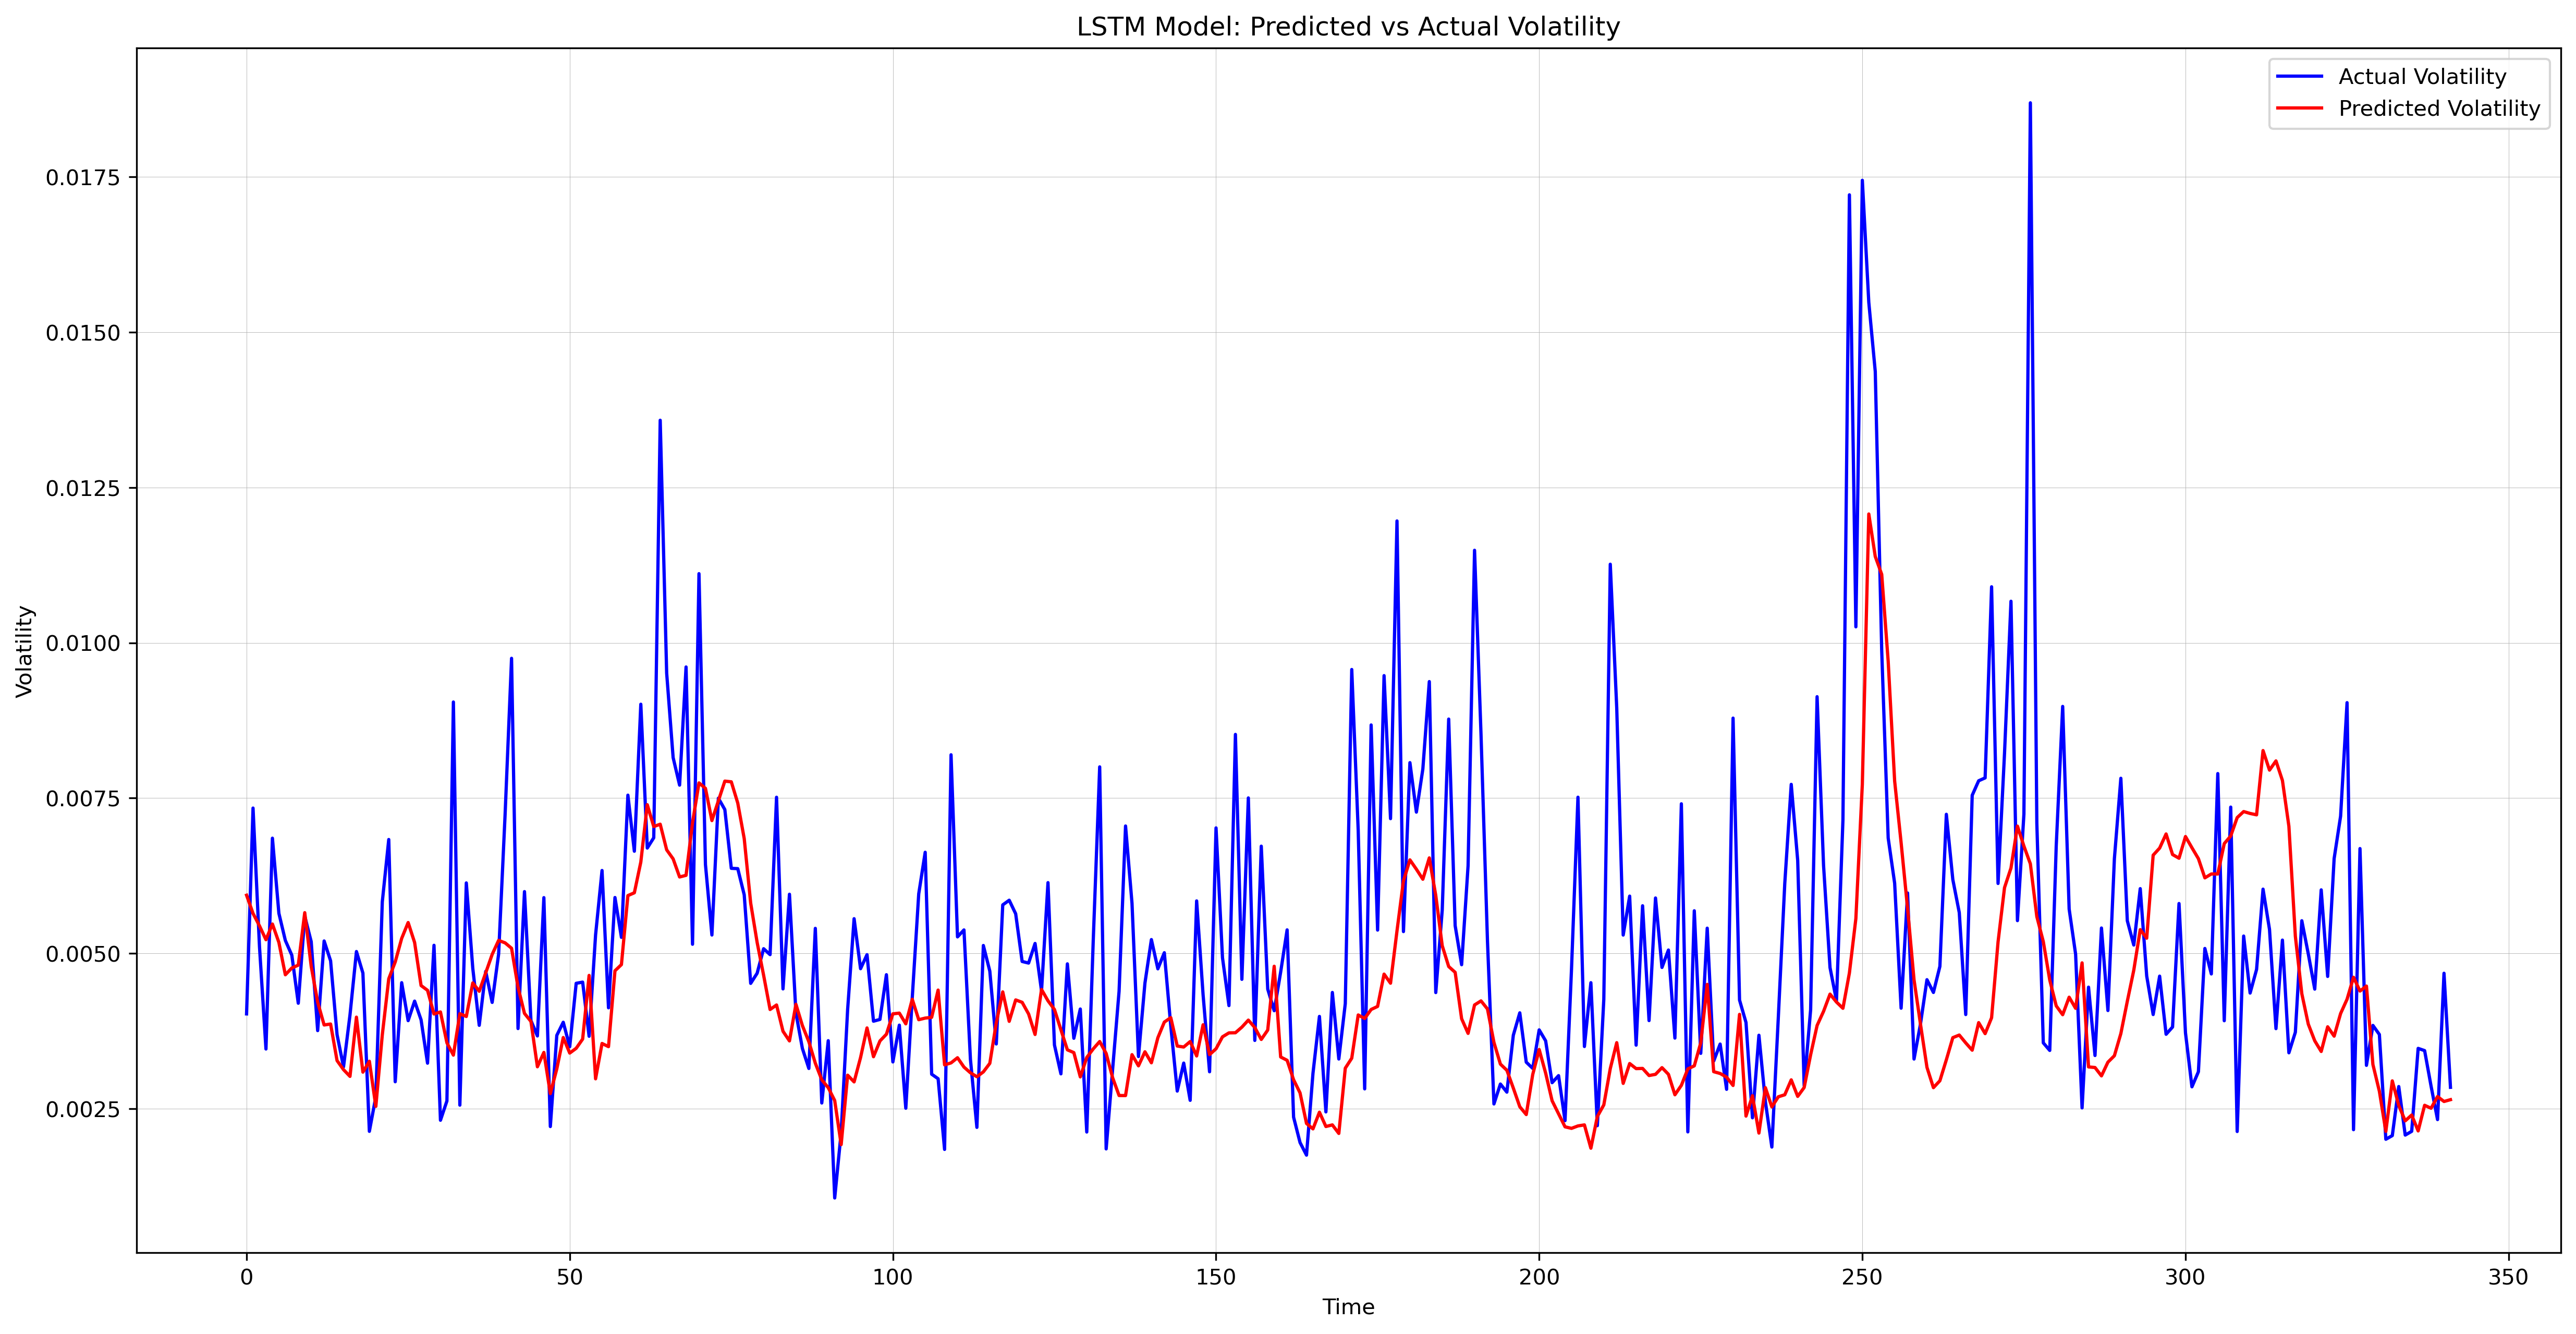


 mse: 0.0006%	 mae: 0.1755%	 mape: 31.9769%


In [76]:
predicted_vol = model.predict(X_test) 
predicted_vol = scaler.inverse_transform(
    np.hstack((predicted_vol, np.zeros((predicted_vol.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

actual_vol = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

# Plot results
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(actual_vol, label="Actual Volatility", color='blue')
plt.plot(predicted_vol, label="Predicted Volatility", color='red')
plt.title("LSTM Model: Predicted vs Actual Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True, linewidth=0.2)
plt.show()

mse = mean_squared_error(actual_vol, predicted_vol)
mae = mean_absolute_error(actual_vol,predicted_vol)
mape = mean_absolute_percentage_error(actual_vol,predicted_vol)

print(f"\n mse: {mse:.4%}\t mae: {mae:.4%}\t mape: {mape:.4%}")
mse = mean_squared_error(actual_vol, predicted_vol)
mae = mean_absolute_error(actual_vol,predicted_vol)
mape = mean_absolute_percentage_error(actual_vol,predicted_vol)

#### RESULTS
no options, simple model, 1 layer lstm

- before:        mse: 0.0018%	 mae: 0.2848%	 mape: 49.0529%
- tes_1_new:     mse: 0.0028%	 mae: 0.3622%	 mape: 41.8643%
no, options, more complexity, 3 layer
- tes_2_new:  mse: 0.0010%	 mae: 0.2382%	 mape: 39.7636%
- 1L w options : mse: 0.0007%	 mae: 0.2098%	 mape: 50.0685%
- simplest without options :  mse: 0.0012%	 mae: 0.2482%	 mape: 40.5661%
- 1LSTM2Lwoptions:  mse: 0.0008%	 mae: 0.2503%	 mape: 65.3719%
- 1LSTM2L: mse: 0.0014%	 mae: 0.2618%	 mape: 42.0063%
- 1GRU2Lwoptions: mse: 0.0008%	 mae: 0.2261%	 mape: 55.6708%
- 1GRU2L:  mse: 0.0016%	 mae: 0.2947%	 mape: 47.3014%
-
- \
with garch as a feature (no optimization)
- 1LSTM2Lwoptions: mse: 0.0007%	 mae: 0.2282%	 mape: 57.7824%
- 1Lwoptions: mse: 0.0007%	 mae: 0.1973%	 mape: 39.7756%     



\
with garch as a feature , also optimization
- 1L_128_garchwoptions_garch: mse: 0.0005%	 mae: 0.1794%	 mape: 41.3535%
- 1Lfixed_units_garopt: mse: 0.0005%	 mae: 0.1593%	 mape: 34.9690%



\
1L_60_garchwoptions_2step
-  mse: 0.0005%	 mae: 0.1636%	 mape: 34.3332%
1L_60_garchwoptions_2step
- mse: 0.0006%	 mae: 0.1897%	 mape: 45.2510%